In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import joblib
import os

In [2]:
import os
file_path = os.path.join("data", "Assessment-2-Associate-DS(in).csv")
df = pd.read_csv(file_path, parse_dates=['weekend_date'])


In [3]:
# Create output folders
os.makedirs("models", exist_ok=True)
os.makedirs("output", exist_ok=True)

In [4]:
df.columns = ['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'serial_num', 'quantity']

In [5]:
serial_nums = df['serial_num'].unique()
forecast_all = []

In [6]:
df['weekend_date'] = pd.to_datetime(df['weekend_date'].str.split().str[0], dayfirst=True, errors='coerce')

In [7]:
df.head()

,weekend_date,channel,brand,category,sub_category,serial_num,quantity
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97


In [12]:
df_s1 = df[df['serial_num'] == 1][['weekend_date', 'quantity']].rename(columns={
        'weekend_date': 'ds',
        'quantity': 'y'
    })

In [13]:
df_s1.head()

,ds,y
0,2022-06-04,56
1,2022-06-11,122
2,2022-06-18,102
3,2022-06-25,128
4,2022-07-02,97


In [14]:
df_s1.tail()

,ds,y
113,2024-08-03,64
114,2024-08-10,63
115,2024-08-17,38
116,2024-08-24,54
117,2024-08-31,78


In [15]:
df_s1 = df_s1.groupby('ds', as_index=False).agg({'y': 'sum'})

In [16]:
df_s1.head()

,ds,y
0,2022-06-04,56
1,2022-06-11,122
2,2022-06-18,102
3,2022-06-25,128
4,2022-07-02,97


In [58]:
df_s1[100:110]

,ds,y
100,2024-05-04,45
101,2024-05-11,28
102,2024-05-18,37
103,2024-05-25,10
104,2024-06-01,24
105,2024-06-08,44
106,2024-06-15,28
107,2024-06-22,24
108,2024-06-29,28
109,2024-07-06,22


In [59]:
train_df = df_s1[df_s1['ds'] < '2024-06-01']
val_df = df_s1[(df_s1['ds'] >= '2024-06-01') & (df_s1['ds'] < '2024-09-01')]

In [60]:
train_df

,ds,y
0,2022-06-04,56
1,2022-06-11,122
2,2022-06-18,102
3,2022-06-25,128
4,2022-07-02,97
...,...,...
99,2024-04-27,46
100,2024-05-04,45
101,2024-05-11,28
102,2024-05-18,37


In [61]:
val_df

,ds,y
104,2024-06-01,24
105,2024-06-08,44
106,2024-06-15,28
107,2024-06-22,24
108,2024-06-29,28
109,2024-07-06,22
110,2024-07-13,32
111,2024-07-20,43
112,2024-07-27,68
113,2024-08-03,64


In [68]:


# Step 2: Make future dataframe to include from 2024-06-01 onwards
# Find number of weeks in val_df
num_weeks = val_df.shape[0]


In [70]:
val_df.shape

(14, 2)

In [69]:
num_weeks

14

In [62]:
model = Prophet()
model.fit(train_df)

21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:49 - cmdstanpy - INFO - Chain [1] done processing


In [74]:

# Step 3: Create future dataframe starting from next Saturday (2024-06-01)
future = model.make_future_dataframe(periods=num_weeks, freq='W-SAT')

# Step 4: Predict
val_forecast = model.predict(future)



In [75]:
val_forecast=val_forecast[['ds','yhat']]

In [80]:
val_forecast[104:]

,ds,yhat
104,2024-06-01,36.752713
105,2024-06-08,35.775444
106,2024-06-15,34.798174
107,2024-06-22,33.820905
108,2024-06-29,32.843635
109,2024-07-06,31.866365
110,2024-07-13,30.889096
111,2024-07-20,29.911826
112,2024-07-27,28.934557
113,2024-08-03,27.957287


In [77]:
val_df

,ds,y
104,2024-06-01,24
105,2024-06-08,44
106,2024-06-15,28
107,2024-06-22,24
108,2024-06-29,28
109,2024-07-06,22
110,2024-07-13,32
111,2024-07-20,43
112,2024-07-27,68
113,2024-08-03,64


In [81]:
val_full = pd.merge(val_df, val_forecast, on='ds', how='left')
val_full

,ds,y,yhat
0,2024-06-01,24,36.752713
1,2024-06-08,44,35.775444
2,2024-06-15,28,34.798174
3,2024-06-22,24,33.820905
4,2024-06-29,28,32.843635
5,2024-07-06,22,31.866365
6,2024-07-13,32,30.889096
7,2024-07-20,43,29.911826
8,2024-07-27,68,28.934557
9,2024-08-03,64,27.957287


In [83]:
import numpy as np


$$
\text{Monthly Accuracy} = 1 - \frac{\sum |\hat{y} - y|}{\sum y}
$$


In [103]:
# Ensure ds column is datetime
val_full['ds'] = pd.to_datetime(val_full['ds'])

# Extract month and year
val_full['month'] = val_full['ds'].dt.month
val_full['year'] = val_full['ds'].dt.year

# Filter for Jun, Jul, Aug 2024 only
val_filtered = val_full[(val_full['year'] == 2024) & (val_full['month'].isin([6, 7, 8]))]

# Group by month
monthly_accuracy = val_filtered.groupby('month').apply(
    lambda x: (1 - (np.abs(x['yhat'] - x['y']).sum() / x['y'].sum()))*100
).reset_index(name='val_accuracy')

C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\2406494508.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_accuracy = val_filtered.groupby('month').apply(


In [104]:
print(monthly_accuracy)

   month  val_accuracy
0      6     19.511261
1      7     54.924588
2      8     74.288530


*Finetuning Model*

In [107]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
import pandas as pd
import numpy as np
import joblib
import os

# 1. Define safer hyperparameter search space
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],         # Moderate flexibility
    'seasonality_prior_scale': [1.0, 5.0],                # Typical values
    'seasonality_mode': ['additive'],                     # Simpler and more stable
    'n_changepoints': [10, 20]                            # Low changepoints = stable fit
}
grid = list(ParameterGrid(param_grid))

In [ ]:
# 2. Accuracy function based on monthly accuracy formula
def monthly_accuracy(y_true, y_pred, dates):
    df = pd.DataFrame({'ds': dates, 'y': y_true, 'yhat': y_pred})
    df['ds'] = pd.to_datetime(df['ds'])
    df['month'] = pd.to_datetime(df['ds']).dt.month
    df['year'] = pd.to_datetime(df['ds']).dt.year
    df = df[(df['year'] == 2024) & (df['month'].isin([6, 7, 8]))]
    acc_df = df.groupby('month').apply(
        lambda x: 1 - (np.abs(x['yhat'] - x['y']).sum() / x['y'].sum())
    )
    return acc_df.mean()  # Average accuracy over months

# 3. Create model folder if it doesn't exist
os.makedirs('model', exist_ok=True)

In [109]:
# 4. Grid search
best_score = -np.inf
best_params = None

for i, params in enumerate(grid):
    print(f"\n▶ Trying config {i+1}/{len(grid)}: {params}")
    
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        n_changepoints=params['n_changepoints'],
        uncertainty_samples=0  # Avoids sampling
    )
    
    model.fit(train_df)

    # Predict over future matching val_df
    future = model.make_future_dataframe(periods=len(val_df), freq='W-SAT')
    forecast = model.predict(future)

    # Align predictions with val_df
    val_pred_df = forecast[forecast['ds'].isin(val_df['ds'])]
    val_merged = pd.merge(val_df, val_pred_df[['ds', 'yhat']], on='ds', how='left')

    # Evaluate monthly accuracy
    acc = monthly_accuracy(val_merged['y'], val_merged['yhat'], val_merged['ds'])

    print(f"🔹 Monthly Accuracy: {acc:.4f}")

    # Keep best config
    if acc > best_score:
        best_score = acc
        best_params = params
        # Save best model
        joblib.dump(model, 'model/prophet_model_best.pkl')

# 5. Print final result
print("\n✅ Best Parameters:", best_params)
print(f"✅ Best Monthly Validation Accuracy: {best_score:.4f}")

00:53:21 - cmdstanpy - INFO - Chain [1] start processing
00:53:21 - cmdstanpy - INFO - Chain [1] done processing



▶ Trying config 1/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
🔹 Monthly Accuracy: 0.5843

▶ Trying config 2/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('month').apply(
00:53:21 - cmdstanpy - INFO - Chain [1] start processing
00:53:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('mo

🔹 Monthly Accuracy: 0.5843

▶ Trying config 3/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
🔹 Monthly Accuracy: 0.5666

▶ Trying config 4/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


00:53:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('month').apply(
00:53:21 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after gr

🔹 Monthly Accuracy: 0.5666

▶ Trying config 5/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
🔹 Monthly Accuracy: 0.5946

▶ Trying config 6/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('month').apply(
00:53:22 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after gr

🔹 Monthly Accuracy: 0.5946

▶ Trying config 7/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
🔹 Monthly Accuracy: 0.5913

▶ Trying config 8/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('month').apply(
00:53:22 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing


🔹 Monthly Accuracy: 0.5913

▶ Trying config 9/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('month').apply(
00:53:22 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('mo

🔹 Monthly Accuracy: 0.5801

▶ Trying config 10/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
🔹 Monthly Accuracy: 0.5801

▶ Trying config 11/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_df = df.groupby('month').apply(
00:53:22 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Omkar Gadade\AppData\Local\Temp\ipykernel_20032\912138952.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after gr

🔹 Monthly Accuracy: 0.5774

▶ Trying config 12/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
🔹 Monthly Accuracy: 0.5774

✅ Best Parameters: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
✅ Best Monthly Validation Accuracy: 0.5946


In [110]:
# 5. Print final result
print("\n✅ Best Parameters:", best_params)
print(f"✅ Best Monthly Validation Accuracy: {best_score:.4f}")


✅ Best Parameters: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
✅ Best Monthly Validation Accuracy: 0.5946


In [200]:
import warnings
warnings.filterwarnings('ignore')


In [201]:
import os
file_path = os.path.join("data", "Assessment-2-Associate-DS(in).csv")
df = pd.read_csv(file_path, parse_dates=['weekend_date'])



In [202]:
# Create output folders
os.makedirs("models", exist_ok=True)
os.makedirs("output", exist_ok=True)

In [203]:
df.columns = ['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'serial_num', 'quantity']

In [204]:
serial_nums = np.sort(df['serial_num'].unique())


In [205]:
serial_nums

array([1, 2, 3, 4, 5], dtype=int64)

In [206]:
df['weekend_date'] = pd.to_datetime(df['weekend_date'].str.split().str[0], dayfirst=True, errors='coerce')

In [207]:
import sys
import os
from prophet import Prophet
from contextlib import redirect_stdout, redirect_stderr




In [209]:
# Loop through all unique serial numbers and run Prophet forecasting for each

for serial in serial_nums:
    # Prepare data for this serial number
    df_serial = df[df['serial_num'] == serial][['weekend_date', 'quantity']].rename(columns={
        'weekend_date': 'ds',
        'quantity': 'y'
    })
    df_serial = df_serial.groupby('ds', as_index=False).agg({'y': 'sum'})

    # Split train/val
    train_df = df_serial[df_serial['ds'] < '2024-06-01']
    val_df = df_serial[(df_serial['ds'] >= '2024-06-01') & (df_serial['ds'] < '2024-09-01')]

    # Fit Prophet
    model = Prophet()
    
    model.fit(train_df)
    
    

    num_weeks = val_df.shape[0]


    # Forecast for validation period
    future = model.make_future_dataframe(periods=num_weeks, freq='W-SAT')
    forecast = model.predict(future)
    val_forecast = forecast[['ds', 'yhat']]
    val_full = pd.merge(val_df, val_forecast, on='ds', how='left')


    # Ensure ds column is datetime
    val_full['ds'] = pd.to_datetime(val_full['ds'])

    # Extract month and year
    val_full['month'] = val_full['ds'].dt.month
    val_full['year'] = val_full['ds'].dt.year

    # Filter for Jun, Jul, Aug 2024 only
    val_filtered = val_full[(val_full['year'] == 2024) & (val_full['month'].isin([6, 7, 8]))]

    # Group by month
    monthly_accuracy = val_filtered.groupby('month').apply(
    lambda x: (1 - (np.abs(x['yhat'] - x['y']).sum() / x['y'].sum()))*100
    ).reset_index(name='val_accuracy')

    print(f"Serial {serial} - Monthly Accuracy:\n{monthly_accuracy}\n")
    print(f"Serial {serial} -Mean Monthly Validation Accuracy: {monthly_accuracy['val_accuracy'].mean():.4f}\n")

    

18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1] done processing
18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1] done processing


Serial 1 - Monthly Accuracy:
   month  val_accuracy
0      6     71.324336
1      7     61.738856
2      8     43.775670

Serial 1 -Mean Monthly Validation Accuracy: 58.9463

Serial 2 - Monthly Accuracy:
   month  val_accuracy
0      6     23.657094
1      7     34.649869
2      8     28.285948

Serial 2 -Mean Monthly Validation Accuracy: 28.8643



18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1] done processing
18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1] done processing


Serial 3 - Monthly Accuracy:
   month  val_accuracy
0      6     20.680870
1      7   -114.292451
2      8     42.190003

Serial 3 -Mean Monthly Validation Accuracy: -17.1405

Serial 4 - Monthly Accuracy:
   month  val_accuracy
0      6     46.068153
1      7     51.370808
2      8      9.758943

Serial 4 -Mean Monthly Validation Accuracy: 35.7326



18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] done processing


Serial 5 - Monthly Accuracy:
   month  val_accuracy
0      6  -7916.496799

Serial 5 -Mean Monthly Validation Accuracy: -7916.4968



# *Final_Code*

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import joblib
import os

In [192]:
import warnings
warnings.filterwarnings('ignore')

In [193]:
import os
file_path = os.path.join("data", "Assessment-2-Associate-DS(in).csv")
df = pd.read_csv(file_path, parse_dates=['weekend_date'])


In [194]:
df.columns = ['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'serial_num', 'quantity']

In [195]:
serial_nums = np.sort(df['serial_num'].unique())

In [196]:
serial_nums

array([1, 2, 3, 4, 5], dtype=int64)

In [197]:
df['weekend_date'] = pd.to_datetime(df['weekend_date'].str.split().str[0], dayfirst=True, errors='coerce')

In [ ]:
# 3. Create model folder if it doesn't exist
os.makedirs('Validation_Models', exist_ok=True)

In [199]:
# Loop through all unique serial numbers and run Prophet forecasting for each hyperparameter configuration

for serial in serial_nums:
    # Prepare data for this serial number
    df_serial = df[df['serial_num'] == serial][['weekend_date', 'quantity']].rename(columns={
        'weekend_date': 'ds',
        'quantity': 'y'
    })
    df_serial = df_serial.groupby('ds', as_index=False).agg({'y': 'sum'})

    # Split train/val
    train_df = df_serial[df_serial['ds'] < '2024-06-01']
    val_df = df_serial[(df_serial['ds'] >= '2024-06-01') & (df_serial['ds'] < '2024-09-01')]


    # 1. Define safer hyperparameter search space
    param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],         # Moderate flexibility
    'seasonality_prior_scale': [1.0, 5.0],                # Typical values
    'seasonality_mode': ['additive'],                     # Simpler and more stable
    'n_changepoints': [10, 20]                            # Low changepoints = stable fit
    }
    grid = list(ParameterGrid(param_grid))

    def monthly_accuracy(y_true, y_pred, dates):
        df = pd.DataFrame({'ds': dates, 'y': y_true, 'yhat': y_pred})
        df['ds'] = pd.to_datetime(df['ds'])
        df['month'] = pd.to_datetime(df['ds']).dt.month
        df['year'] = pd.to_datetime(df['ds']).dt.year
        df = df[(df['year'] == 2024) & (df['month'].isin([6, 7, 8]))]
        acc_df = df.groupby('month').apply(
        lambda x: 1 - (np.abs(x['yhat'] - x['y']).sum() / x['y'].sum())
        )
        return acc_df.mean()  # Average accuracy over months

    

    # 4. Grid search
    best_score = -np.inf
    best_params = None

    for i, params in enumerate(grid):
        print(f"\n▶ Serial_no{serial}: Trying config {i+1}/{len(grid)}: {params}")
    
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            n_changepoints=params['n_changepoints'],
            uncertainty_samples=0  # Avoids sampling
        )
    
        model.fit(train_df)

        # Predict over future matching val_df
        future = model.make_future_dataframe(periods=len(val_df), freq='W-SAT')
        forecast = model.predict(future)

        # Align predictions with val_df
        val_pred_df = forecast[forecast['ds'].isin(val_df['ds'])]
        val_merged = pd.merge(val_df, val_pred_df[['ds', 'yhat']], on='ds', how='left')

        # Evaluate monthly accuracy
        acc = monthly_accuracy(val_merged['y'], val_merged['yhat'], val_merged['ds'])

        print(f"Monthly Accuracy for Serial No {serial}: {acc:.4f}")

        # Keep best config
        if acc > best_score:
            best_score = acc
            best_params = params
            # Save best model
            joblib.dump(model, f'Validation_Models/validation_bestmodel_Serial_no{serial}.pkl')
    
    # 5. Print final result
    print(f"\nSerial_no:{serial} Best Parameters:", best_params)
    print(f"Serial_no:{serial} Best Monthly Validation Accuracy: {best_score:.4f}")
    print("\n" + "="*50 + "\n")

   

03:49:47 - cmdstanpy - INFO - Chain [1] start processing
03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing



▶ Serial_no1: Trying config 1/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Monthly Accuracy for Serial No 1: 0.5843

▶ Serial_no1: Trying config 2/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing
03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing
03:49:47 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 1: 0.5843

▶ Serial_no1: Trying config 3/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Monthly Accuracy for Serial No 1: 0.5666

▶ Serial_no1: Trying config 4/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 1: 0.5666

▶ Serial_no1: Trying config 5/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:47 - cmdstanpy - INFO - Chain [1] start processing
03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing
03:49:47 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 1: 0.5946

▶ Serial_no1: Trying config 6/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 1: 0.5946

▶ Serial_no1: Trying config 7/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:47 - cmdstanpy - INFO - Chain [1] start processing
03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:48 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 1: 0.5913

▶ Serial_no1: Trying config 8/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 1: 0.5913

▶ Serial_no1: Trying config 9/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 1: 0.5801

▶ Serial_no1: Trying config 10/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 1: 0.5801

▶ Serial_no1: Trying config 11/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 1: 0.5774

▶ Serial_no1: Trying config 12/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 1: 0.5774

Serial_no:1 Best Parameters: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Serial_no:1 Best Monthly Validation Accuracy: 0.5946



▶ Serial_no2: Trying config 1/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:48 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 2: 0.3044

▶ Serial_no2: Trying config 2/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 2: 0.3044

▶ Serial_no2: Trying config 3/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing
03:49:49 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 2: 0.2992

▶ Serial_no2: Trying config 4/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 2: 0.2992

▶ Serial_no2: Trying config 5/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:49 - cmdstanpy - INFO - Chain [1] start processing
03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing
03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 2: 0.2886

▶ Serial_no2: Trying config 6/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 2: 0.2886

▶ Serial_no2: Trying config 7/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing
03:49:49 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 2: 0.2886

▶ Serial_no2: Trying config 8/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 2: 0.2886

▶ Serial_no2: Trying config 9/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:49 - cmdstanpy - INFO - Chain [1] start processing
03:49:50 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing
03:49:50 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 2: 0.2910

▶ Serial_no2: Trying config 10/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 2: 0.2910

▶ Serial_no2: Trying config 11/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:50 - cmdstanpy - INFO - Chain [1] start processing
03:49:50 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing
03:49:50 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 2: 0.2906

▶ Serial_no2: Trying config 12/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 2: 0.2906

Serial_no:2 Best Parameters: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Serial_no:2 Best Monthly Validation Accuracy: 0.3044



▶ Serial_no3: Trying config 1/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:50 - cmdstanpy - INFO - Chain [1] start processing
03:49:50 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing
03:49:50 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 3: -0.1744

▶ Serial_no3: Trying config 2/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 3: -0.1744

▶ Serial_no3: Trying config 3/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:50 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing
03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 3: -0.1478

▶ Serial_no3: Trying config 4/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 3: -0.1478

▶ Serial_no3: Trying config 5/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing
03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 3: -0.1429

▶ Serial_no3: Trying config 6/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 3: -0.1429

▶ Serial_no3: Trying config 7/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing
03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:52 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 3: -0.1389

▶ Serial_no3: Trying config 8/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


03:49:52 - cmdstanpy - INFO - Chain [1] start processing
03:49:52 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 3: -0.1389

▶ Serial_no3: Trying config 9/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Monthly Accuracy for Serial No 3: -1.6733

▶ Serial_no3: Trying config 10/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


03:49:52 - cmdstanpy - INFO - Chain [1] start processing
03:49:52 - cmdstanpy - INFO - Chain [1] done processing
03:49:52 - cmdstanpy - INFO - Chain [1] start processing
03:49:52 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 3: -1.6733

▶ Serial_no3: Trying config 11/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:52 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 3: -1.8777

▶ Serial_no3: Trying config 12/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}


03:49:52 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 3: -1.8777

Serial_no:3 Best Parameters: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Serial_no:3 Best Monthly Validation Accuracy: -0.1389



▶ Serial_no4: Trying config 1/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 4: 0.3568

▶ Serial_no4: Trying config 2/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 4: 0.3568

▶ Serial_no4: Trying config 3/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 4: 0.3583

▶ Serial_no4: Trying config 4/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 4: 0.3583

▶ Serial_no4: Trying config 5/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 4: 0.3575

▶ Serial_no4: Trying config 6/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 4: 0.3575

▶ Serial_no4: Trying config 7/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 4: 0.3561

▶ Serial_no4: Trying config 8/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 4: 0.3561

▶ Serial_no4: Trying config 9/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 4: 0.3595

▶ Serial_no4: Trying config 10/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 4: 0.3595

▶ Serial_no4: Trying config 11/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 4: 0.3573

▶ Serial_no4: Trying config 12/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 4: 0.3573

Serial_no:4 Best Parameters: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Serial_no:4 Best Monthly Validation Accuracy: 0.3595



▶ Serial_no5: Trying config 1/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 5: -85.5770

▶ Serial_no5: Trying config 2/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 5: -85.5770

▶ Serial_no5: Trying config 3/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 5: -93.5601

▶ Serial_no5: Trying config 4/12: {'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 5: -93.5601

▶ Serial_no5: Trying config 5/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


Monthly Accuracy for Serial No 5: -82.4197

▶ Serial_no5: Trying config 6/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 5: -82.4197

▶ Serial_no5: Trying config 7/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 5: -78.6222

▶ Serial_no5: Trying config 8/12: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 5: -78.6222

▶ Serial_no5: Trying config 9/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:55 - cmdstanpy - INFO - Chain [1] start processing
03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:56 - cmdstanpy - INFO - Chain [1] start processing
03:49:56 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 5: -80.2379

▶ Serial_no5: Trying config 10/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 5: -80.2379

▶ Serial_no5: Trying config 11/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:49:56 - cmdstanpy - INFO - Chain [1] start processing
03:49:56 - cmdstanpy - INFO - Chain [1] done processing


Monthly Accuracy for Serial No 5: -79.9796

▶ Serial_no5: Trying config 12/12: {'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.0}
Monthly Accuracy for Serial No 5: -79.9796

Serial_no:5 Best Parameters: {'changepoint_prior_scale': 0.05, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}
Serial_no:5 Best Monthly Validation Accuracy: -78.6222




# *Now to forecast the next 3 months quantity i.e september, october and november 2024, using the saved .pkl best models for each Serial_No*

# *For Serial 1 Model Forecast for Sep to Nov 2024*

In [260]:
import joblib  # or import pickle if you used that

# Load the trained Prophet model
model = joblib.load("Final_Models (pkl_files)/prophet_bestmodel_Serial_no1.pkl") 

In [261]:
# Extend the time range to forecast next 28 weeks (~6 months)
future = model.make_future_dataframe(periods=28, freq='W')  # Weekly frequency


In [262]:
forecast = model.predict(future)

# Filter only for the forecasted Sep–Nov range
forecast_result = forecast[(forecast['ds'] >= '2024-09-01') & (forecast['ds'] <= '2024-11-30')]

# Display relevant forecast columns
forecast_result[['ds', 'yhat']]

,ds,yhat
118,2024-09-01,25.814265
119,2024-09-08,24.879003
120,2024-09-15,23.943742
121,2024-09-22,23.008480
122,2024-09-29,22.073219
123,2024-10-06,21.137957
124,2024-10-13,20.202696
125,2024-10-20,19.267434
126,2024-10-27,18.332173
127,2024-11-03,17.396911


Figure(1000x600)


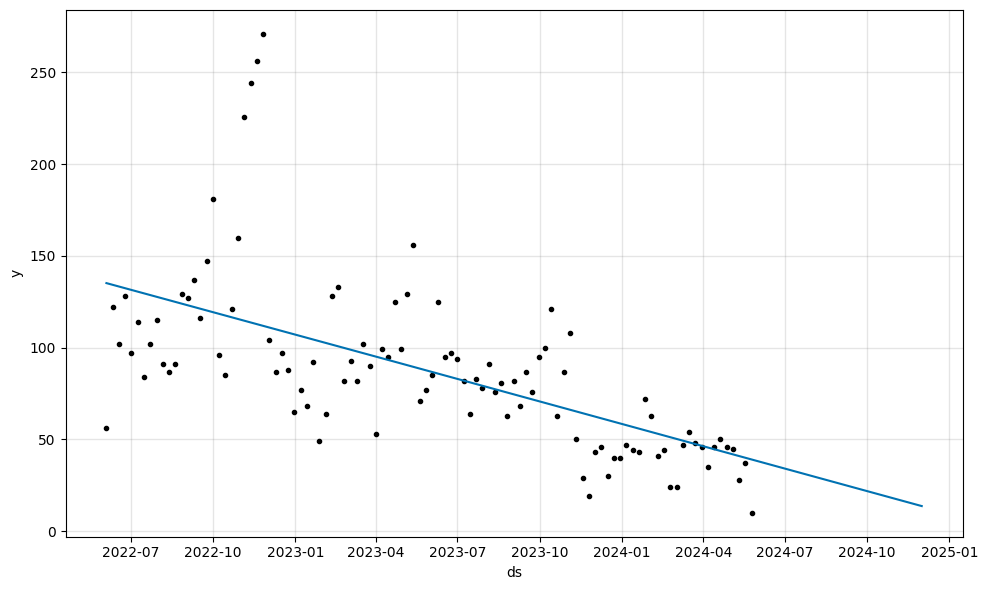

In [263]:
# Plot the entire forecast including Sep–0ct-Nov 2024 for Serial no 1 quantites
print(model.plot(forecast))


# *Forecast result saved in output folder*

In [ ]:
# Save forecast results for Sep–Nov
forecast_result[['ds', 'yhat']].to_csv("Forecast output (csv_files)/forecast_sep_oct_nov_2024_Model_Serial_No_1.csv", index=False)


# *For Serial Number 2*

In [264]:
import joblib  # or import pickle if you used that

# Load the trained Prophet model
model = joblib.load("Final_Models (pkl_files)/prophet_bestmodel_Serial_no2.pkl") 


# Extend the time range to forecast next 28 weeks (~6 months)
future = model.make_future_dataframe(periods=28, freq='W')  # Weekly frequency


forecast = model.predict(future)

# Filter only for the forecasted Sep–Nov range
forecast_result = forecast[(forecast['ds'] >= '2024-09-01') & (forecast['ds'] <= '2024-11-30')]

# Display relevant forecast columns
forecast_result[['ds', 'yhat']]

,ds,yhat
110,2024-09-01,307.329337
111,2024-09-08,308.041677
112,2024-09-15,308.754017
113,2024-09-22,309.466357
114,2024-09-29,310.178698
115,2024-10-06,310.891038
116,2024-10-13,311.603378
117,2024-10-20,312.315718
118,2024-10-27,313.028058
119,2024-11-03,313.740398


Figure(1000x600)


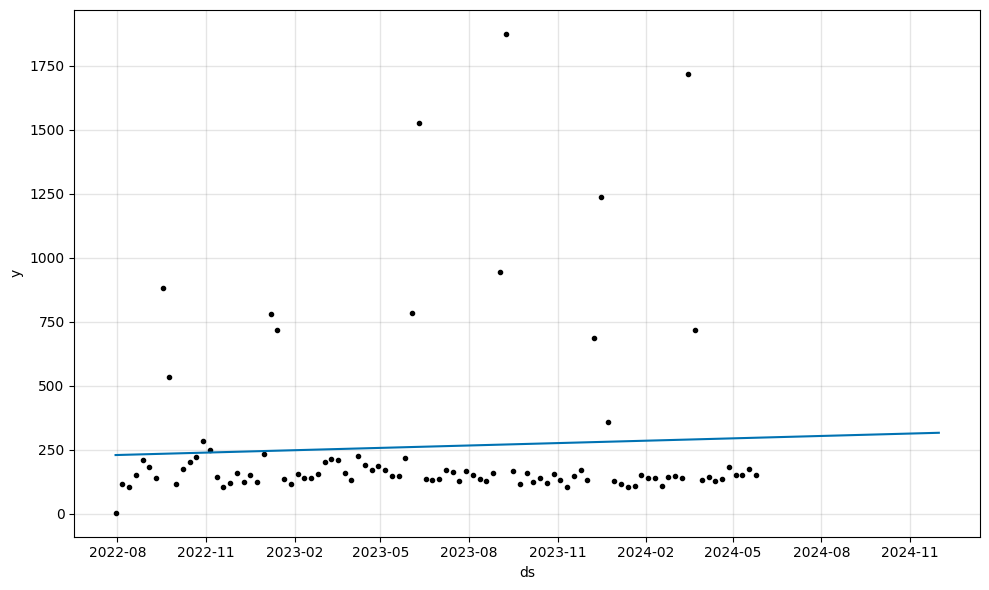

In [265]:
# Plot the entire forecast including Sep-oct-Nov for Serial no 2 quantites
print(model.plot(forecast))


In [266]:
# Save forecast results for Sep–Nov
forecast_result[['ds', 'yhat']].to_csv("Forecast output (csv_files)/forecast_sep_oct_nov_2024_Model_Serial_No_2.csv", index=False)


# *For Serial No 3 Model*

In [267]:
import joblib  # or import pickle if you used that

# Load the trained Prophet model
model = joblib.load("Final_Models (pkl_files)/prophet_bestmodel_Serial_no3.pkl") 


# Extend the time range to forecast next 28 weeks (~6 months)
future = model.make_future_dataframe(periods=28, freq='W')  # Weekly frequency


forecast = model.predict(future)

# Filter only for the forecasted Sep–Nov range
forecast_result = forecast[(forecast['ds'] >= '2024-09-01') & (forecast['ds'] <= '2024-11-30')]

# Display relevant forecast columns
forecast_result[['ds', 'yhat']]

,ds,yhat
107,2024-09-01,36.940682
108,2024-09-08,23.087937
109,2024-09-15,9.235192
110,2024-09-22,-4.617552
111,2024-09-29,-18.470297
112,2024-10-06,-32.323042
113,2024-10-13,-46.175787
114,2024-10-20,-60.028532
115,2024-10-27,-73.881277
116,2024-11-03,-87.734022


Figure(1000x600)


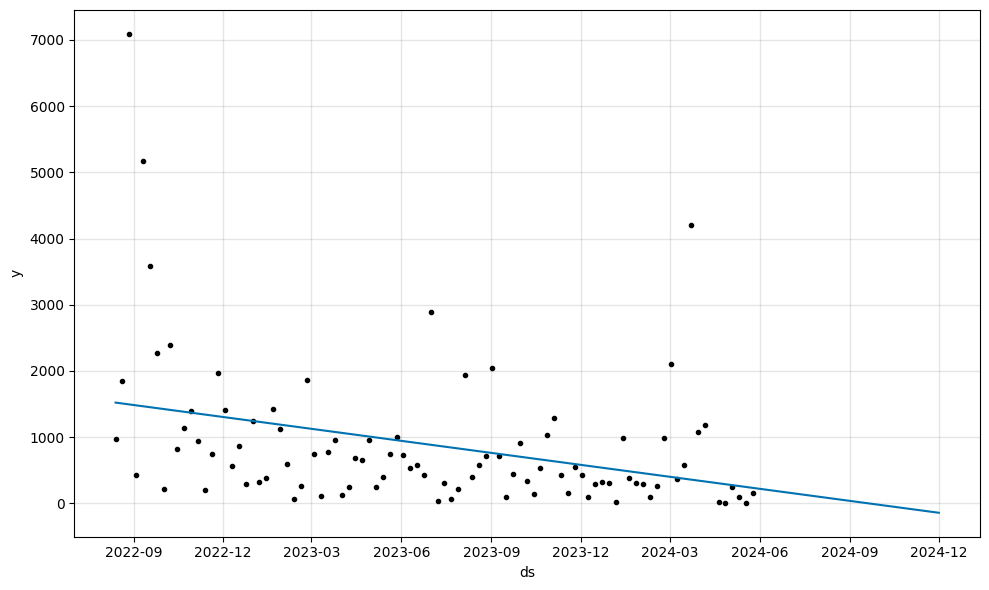

In [268]:
print(model.plot(forecast))

In [269]:
# Save forecast results for Sep–Nov
forecast_result[['ds', 'yhat']].to_csv("Forecast output (csv_files)/forecast_sep_oct_nov_2024_Model_Serial_No_3.csv", index=False)

# *For Serial No 4 Model*

In [271]:
import joblib  # or import pickle if you used that

# Load the trained Prophet model
model = joblib.load("Final_Models (pkl_files)/prophet_bestmodel_Serial_no4.pkl") 


# Extend the time range to forecast next 28 weeks (~6 months)
future = model.make_future_dataframe(periods=28, freq='W')  # Weekly frequency


forecast = model.predict(future)

# Filter only for the forecasted Sep–Nov range
forecast_result = forecast[(forecast['ds'] >= '2024-09-01') & (forecast['ds'] <= '2024-11-30')]

# Display relevant forecast columns
forecast_result[['ds', 'yhat']]

,ds,yhat
85,2024-09-01,3181.717998
86,2024-09-08,3209.674415
87,2024-09-15,3237.630832
88,2024-09-22,3265.587249
89,2024-09-29,3293.543665
90,2024-10-06,3321.500082
91,2024-10-13,3349.456499
92,2024-10-20,3377.412916
93,2024-10-27,3405.369332
94,2024-11-03,3433.325749


Figure(1000x600)


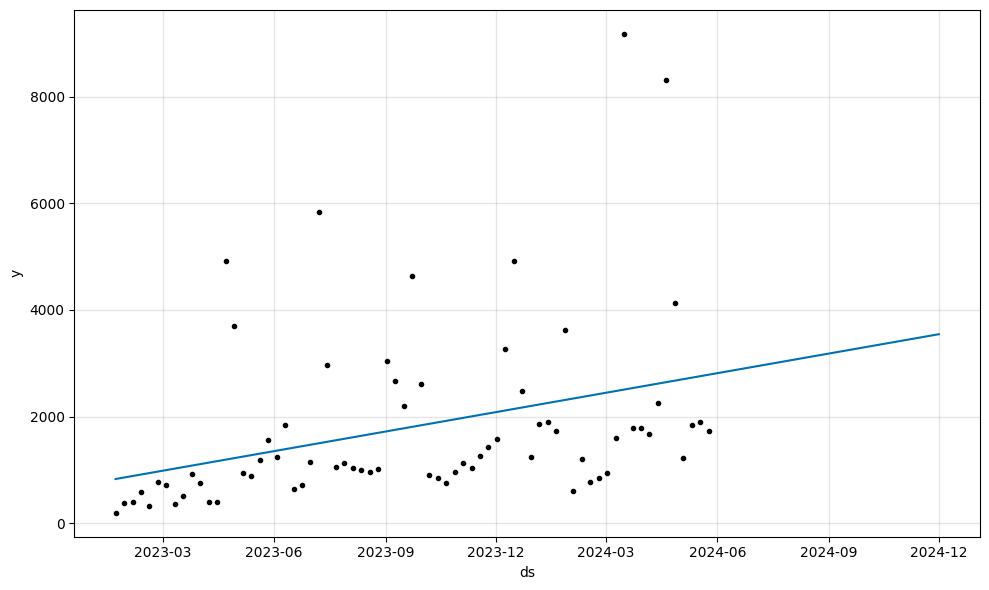

In [272]:
print(model.plot(forecast))

In [273]:
# Save forecast results for Sep–Nov
forecast_result[['ds', 'yhat']].to_csv("Forecast output (csv_files)/forecast_sep_oct_nov_2024_Model_Serial_No_4.csv", index=False)

# *For Serial No 5 Model*

In [274]:
import joblib  # or import pickle if you used that

# Load the trained Prophet model
model = joblib.load("Final_Models (pkl_files)/prophet_bestmodel_Serial_no5.pkl") 


# Extend the time range to forecast next 28 weeks (~6 months)
future = model.make_future_dataframe(periods=28, freq='W')  # Weekly frequency


forecast = model.predict(future)

# Filter only for the forecasted Sep–Nov range
forecast_result = forecast[(forecast['ds'] >= '2024-09-01') & (forecast['ds'] <= '2024-11-30')]

# Display relevant forecast columns
forecast_result[['ds', 'yhat']]

,ds,yhat
118,2024-09-01,225.416602
119,2024-09-08,223.940332
120,2024-09-15,222.464063
121,2024-09-22,220.987793
122,2024-09-29,219.511523
123,2024-10-06,218.035254
124,2024-10-13,216.558984
125,2024-10-20,215.082714
126,2024-10-27,213.606445
127,2024-11-03,212.130175


Figure(1000x600)


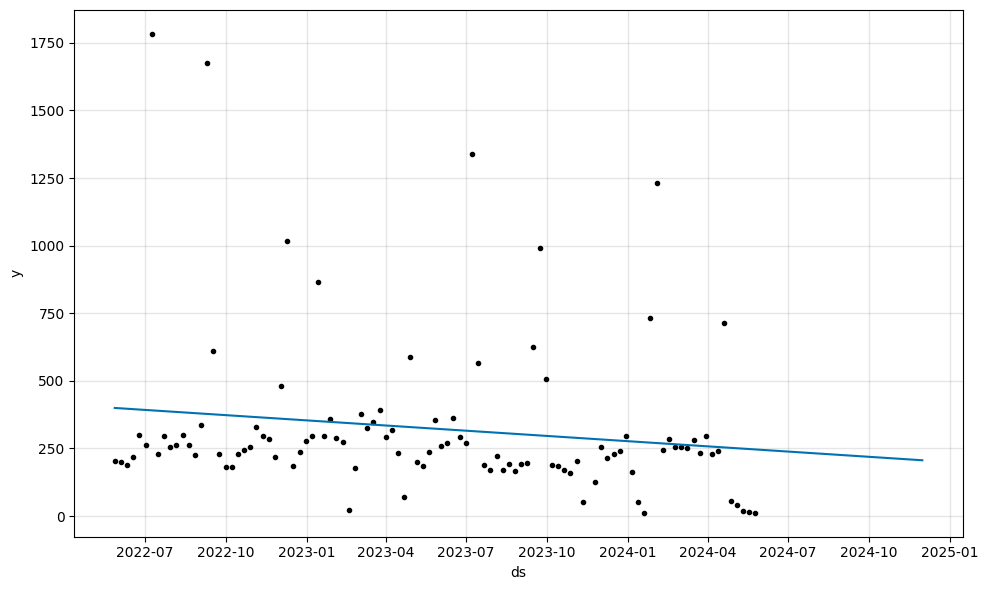

In [275]:
print(model.plot(forecast))

In [ ]:
# Save forecast results for Sep–Nov
forecast_result[['ds', 'yhat']].to_csv("Forecast output (csv_files)/forecast_sep_oct_nov_2024_Model_Serial_No_5.csv", index=False)